### Task
Try to learn the ff: formula

$\text{Given that:}$
$r = \sqrt{x^2 + y^2} \quad \text{where: } r, x, y \in [0, 1]$ 

/Users/jums/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/jums/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/distributions.py:1128: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)
/Users/jums/miniconda3/envs/ml/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


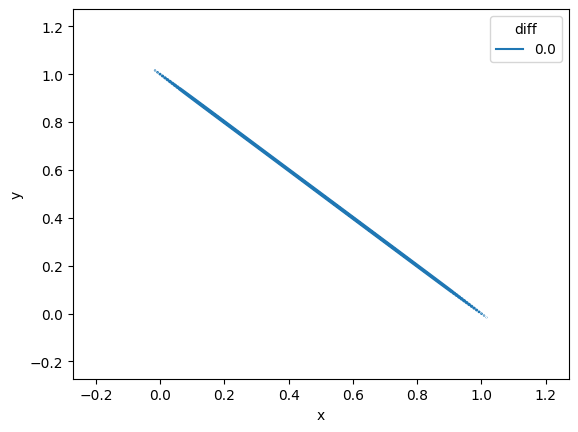

In [16]:
import jax.numpy as jnp
import math
import matplotlib.pyplot as plt
from jax import grad, jit, vmap, jacobian
from jaxlib.xla_extension import ArrayImpl
import math
import seaborn as sns
import pandas as pd
import jax

key =  jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
x0_input = jax.random.uniform(key, shape=(1000,1), dtype=jnp.float32)
x1_input = 1.0 - x0_input
x_input = jnp.column_stack([x0_input, x1_input])
y_target = jnp.sum(x_input ** 2, axis=1).reshape(-1,1)
y_diff = y_target - y_target
data = jnp.column_stack([x_input, y_diff])
data = pd.DataFrame(data, columns=['x', 'y', 'diff'])
sns.kdeplot(data, x='x', y='y', cmap='reds', hue='diff')
plt.show()



In [35]:
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jaxlib.xla_extension import ArrayImpl
import math
from jax.scipy.special import logsumexp


# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (m, n)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(input_sizes, output_sizes, key):
  assert len(input_sizes) == len(output_sizes), 'input_sizes != output_sizes'
  keys = random.split(key, len(input_sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(input_sizes, output_sizes, keys)]

def display_params(params, params_name):
   print(f'{params_name} total num_layers = ', len(params))
   for level, param in enumerate(params, start=1):
      weight_shape = param[0].shape
      bias_shape = param[1].shape
      print(f'({level}) {params_name}_weights.shape = {weight_shape}, {params_name}_bias.shape = {bias_shape}')



network_params total num_layers =  2
(1) network_params_weights.shape = (1, 5), network_params_bias.shape = (5,)
(2) network_params_weights.shape = (5, 1), network_params_bias.shape = (1,)


In [48]:
def relu(x):
    return jnp.where(x >= 0, x, 0)

def mse(y_pred,y_target):
    return jnp.mean((y_pred - y_target) ** 2)

def linear(W, x):
    return x @ W

def predict(params, x_input):
    activations = x_input 
    for w, b in params[:-1]:
        outputs = activations @ w + b
        activations = relu(outputs)
    
    final_w = params[-1][0]
    final_b = params[-1][1]

    logits = activations @ final_w + final_b
    return jnp.tanh(logits)

@jit
def loss_func(params, x_input, targets):
  preds = predict(params, x_input)
  return mse(preds, targets)

### TODO:
- Investigate if these weights are actually computing the right gradients. Such that it computes $\partial f(x; \omega_{ij}) / \partial \omega_{ij}$ where $\omega_{ij}$ is the weights.
- Create a focused notebook on this part.

network_params total num_layers =  2
(1) network_params_weights.shape = (1, 10), network_params_bias.shape = (10,)
(2) network_params_weights.shape = (10, 1), network_params_bias.shape = (1,)
[1000/10000] Loss: 0.11944948881864548
[2000/10000] Loss: 0.09581971913576126
[3000/10000] Loss: 0.08959004282951355
[4000/10000] Loss: 0.08747266978025436
[5000/10000] Loss: 0.08656696230173111
[6000/10000] Loss: 0.0860384926199913
[7000/10000] Loss: 0.08545566350221634
[8000/10000] Loss: 0.08435731381177902
[9000/10000] Loss: 0.08205899596214294
[10000/10000] Loss: 0.07788324356079102


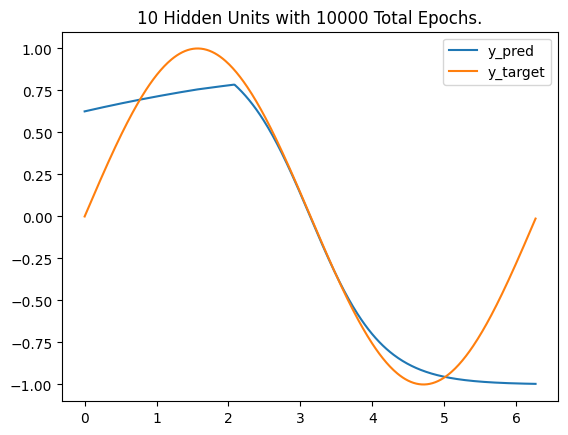

In [56]:

def update_weights(params, x, y, step_size):
  grads = grad(loss_func)(params, x, y)

  return [(w - step_size * dw, b - step_size * db)
          for (w, b), (dw, db) in zip(params, grads)]

def train_network(num_hidden, num_epochs, step_display):
  input_sizes = [1, num_hidden]
  output_sizes = [num_hidden, 1]
  params = init_network_params(input_sizes, output_sizes, random.PRNGKey(0))
  display_params(params, 'network_params')
  step_size = 0.01

  for curr_epoch in range(1, num_epochs + 1):
    loss = loss_func(params, x_input, y_target)
    params = update_weights(params, x_input, y_target, step_size)
    if curr_epoch % step_display == 0:
      print(f'[{curr_epoch}/{num_epochs}] Loss: {loss}')

  y_pred = predict(params, x_input)
  plt.plot(x_input.reshape(-1), y_pred.reshape(-1), label='y_pred')
  plt.plot(x_input.reshape(-1), y_target.reshape(-1), label='y_target')
  plt.legend()
  plt.title(f'{num_hidden} Hidden Units with {num_epochs} Total Epochs.')
  plt.show()

train_network(10, 10000, 1000)

network_params total num_layers =  2
(1) network_params_weights.shape = (1, 100), network_params_bias.shape = (100,)
(2) network_params_weights.shape = (100, 1), network_params_bias.shape = (1,)
[1000/10000] Loss: 0.11587703227996826
[2000/10000] Loss: 0.09533773362636566
[3000/10000] Loss: 0.08950122445821762
[4000/10000] Loss: 0.08739180117845535
[5000/10000] Loss: 0.08617500215768814
[6000/10000] Loss: 0.08507242053747177
[7000/10000] Loss: 0.08333409577608109
[8000/10000] Loss: 0.08014902472496033
[9000/10000] Loss: 0.07500065863132477
[10000/10000] Loss: 0.06857405602931976


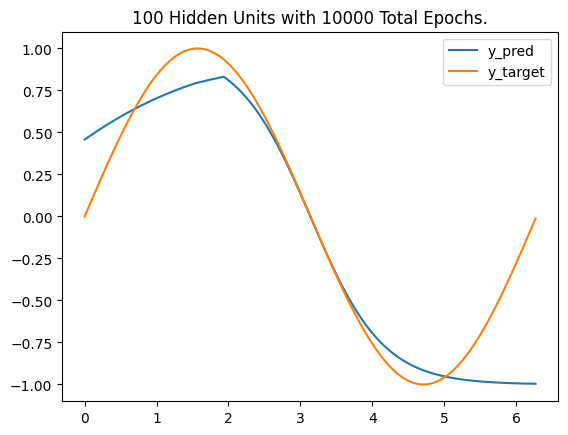

In [54]:
train_network(100, 10000, 1000)

network_params total num_layers =  2
(1) network_params_weights.shape = (1, 100), network_params_bias.shape = (100,)
(2) network_params_weights.shape = (100, 1), network_params_bias.shape = (1,)
[5000/50000] Loss: 0.08617500215768814
[10000/50000] Loss: 0.06857405602931976
[15000/50000] Loss: 0.05630406737327576
[20000/50000] Loss: 0.05585045740008354
[25000/50000] Loss: 0.055823516100645065
[30000/50000] Loss: 0.05581412836909294
[35000/50000] Loss: 0.055806513875722885
[40000/50000] Loss: 0.05579982325434685
[45000/50000] Loss: 0.05579347163438797
[50000/50000] Loss: 0.05578524246811867


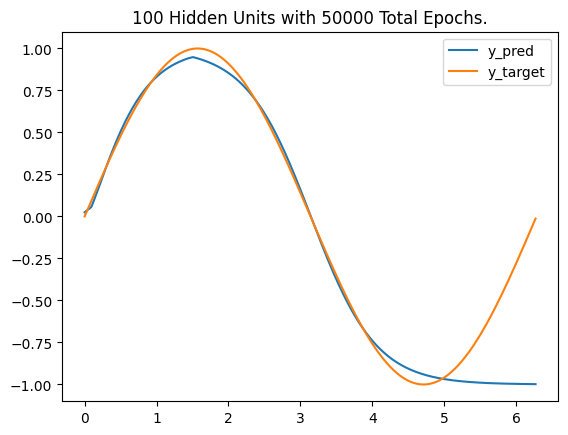

In [57]:
train_network(100, 50000, 5000)

network_params total num_layers =  2
(1) network_params_weights.shape = (1, 2), network_params_bias.shape = (2,)
(2) network_params_weights.shape = (2, 1), network_params_bias.shape = (1,)
[1000/20000] Loss: 0.11886030435562134
[2000/20000] Loss: 0.0954960361123085
[3000/20000] Loss: 0.08946634083986282
[4000/20000] Loss: 0.087444968521595
[5000/20000] Loss: 0.08666979521512985
[6000/20000] Loss: 0.08634106814861298
[7000/20000] Loss: 0.08619162440299988
[8000/20000] Loss: 0.08612115681171417
[9000/20000] Loss: 0.08608666062355042
[10000/20000] Loss: 0.08606922626495361
[11000/20000] Loss: 0.08606062829494476
[12000/20000] Loss: 0.08605557680130005
[13000/20000] Loss: 0.08605241775512695
[14000/20000] Loss: 0.08604966849088669
[15000/20000] Loss: 0.08604655414819717
[16000/20000] Loss: 0.08604197949171066
[17000/20000] Loss: 0.08603456616401672
[18000/20000] Loss: 0.08602213114500046
[19000/20000] Loss: 0.08600099384784698
[20000/20000] Loss: 0.08596494793891907


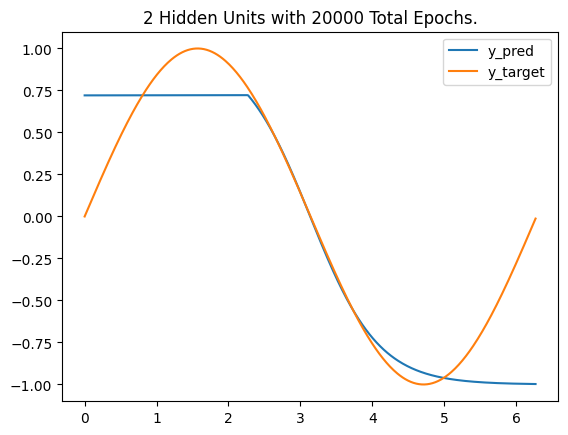

In [59]:
train_network(2, 20000, 1000)